# Estimate forcing for historical and SSPs

In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plot_allvar = False
plot_tasandN = False
plot_modes = False

saveforcingdata = True # create one file for each model/exp/member, combine them later if needed
saveforcingfigure = True


In [90]:
#model = 'ACCESS-CM2'; member = 'r1i1p1f1'
#model = 'ACCESS-ESM1-5'; member = 'r1i1p1f1'
#model = 'AWI-CM-1-1-MR'; member = 'r1i1p1f1'
#model = 'BCC-CSM2-MR'; member = 'r1i1p1f1'
#model = 'BCC-ESM1'; member = 'r1i1p1f1'
#model = 'CAMS-CSM1-0'; member = 'r1i1p1f1'
#model = 'CAMS-CSM1-0'; member = 'r2i1p1f1'
#model = 'CanESM5'; member = 'r1i1p1f1'
#model = 'CanESM5'; member = 'r1i1p2f1'
#model = 'CESM2'; member = 'r1i1p1f1'
#model = 'CESM2-WACCM'; member = 'r1i1p1f1'
#model = 'CNRM-CM6-1'; member = 'r1i1p1f2'
#model = 'CNRM-ESM2-1'; member = 'r1i1p1f2'
#model = 'E3SM-1-0'; member = 'r1i1p1f1'
#model = 'EC-Earth3'; member = 'r1i1p1f1' #member = 'r3i1p1f1'
#model = 'GFDL-CM4'; member = 'r1i1p1f1'
#model = 'GFDL-ESM4'; member = 'r1i1p1f1'
#model = 'GISS-E2-1-G'; member = 'r1i1p1f1'
#model = 'HadGEM3-GC31-LL'; member = 'r1i1p1f3'
#model = 'INM-CM4-8'; member = 'r1i1p1f1'
#model = 'INM-CM5-0'; member = 'r1i1p1f1'
#model = 'IPSL-CM6A-LR'; member = 'r1i1p1f1'
#model = 'MIROC-ES2L'; member = 'r1i1p1f2'
#model = 'MIROC6'; member = 'r1i1p1f1'
#model = 'MPI-ESM1-2-HR'; member = 'r1i1p1f1'
#model = 'MPI-ESM1-2-LR'; member = 'r1i1p1f1'
#model = 'MRI-ESM2-0'; member = 'r1i1p1f1'
#model = 'MRI-ESM2-0'; member = 'r1i2p1f1'
#model = 'MRI-ESM2-0'; member = 'r4i1p1f1'
#model = 'MRI-ESM2-0'; member = 'r7i1p1f1'
#model = 'MRI-ESM2-0'; member = 'r10i1p1f1'
#model = 'MRI-ESM2-0'; member = 'r13i1p1f1'
#model = 'NorESM2-LM'; member = 'r1i1p1f1'
#model = 'NorESM2-MM'; member = 'r1i1p1f1'
model = 'UKESM1-0-LL'; member = 'r1i1p1f2'

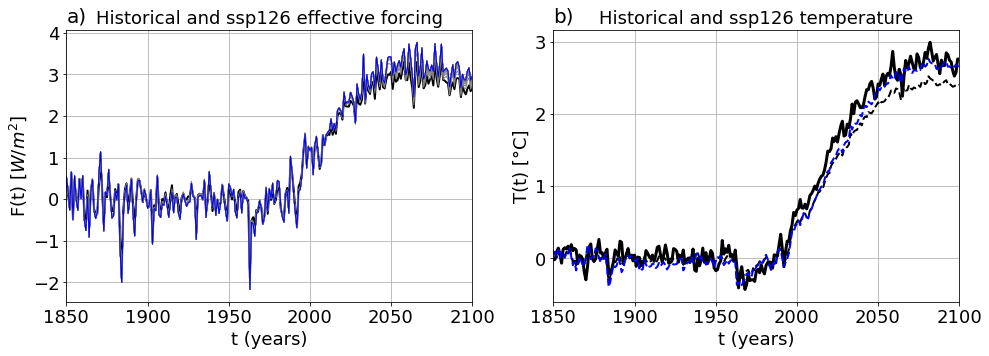

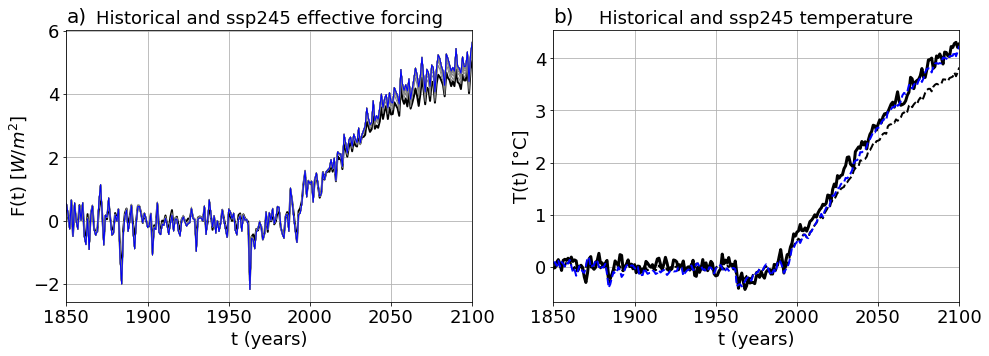

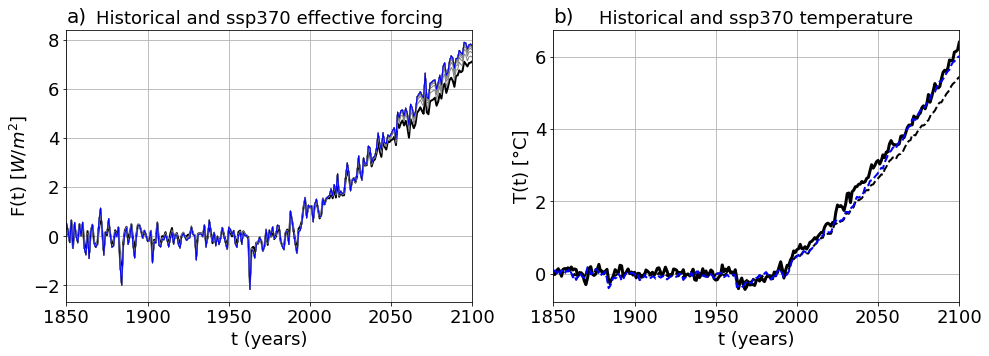

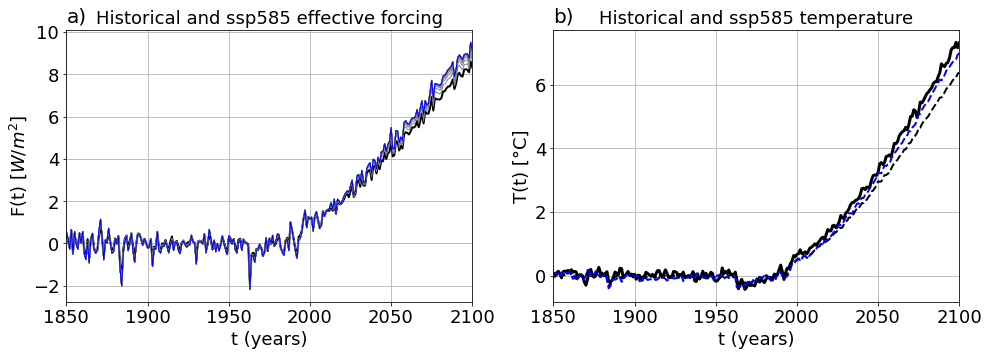

In [94]:
for exp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:

    # load historical and ssp data, and combine the time series
    modeldir = '../Processed_data/Global_annual_anomalies/'

    historical_file = model + '_historical_' + member + '_anomalies.txt'
    historical = pd.read_table(modeldir + model + '/historical/' + historical_file, index_col=0, sep = ',')

    ssp_file = model + '_' + exp + '_' + member + '_anomalies.txt'
    ssp = pd.read_table(modeldir + model + '/' + exp + '/' + ssp_file, index_col=0, sep = ',')

    data = pd.concat([historical, ssp], ignore_index = True)
    N = data['rsdt'] - data['rsut'] - data['rlut']

    years = np.arange(1850, 1850+len(data));
    variables = list(data)
    units = [' [K]', ' [W/$m^2$]', ' [W/$m^2$]', ' [W/$m^2$]']

    if plot_allvar == True:
        # plot data for all variables
        fig, axes = plt.subplots(nrows=2,ncols=2,figsize = [16,10])
        fig.suptitle(model + ' historical and ' + exp + ' ' + member,fontsize = 18)
        ax = np.concatenate(axes)
        for (j, var) in enumerate(variables):
            ax[j].plot(years, data[var], linewidth=2,color = "black")
            ax[j].set_ylabel(var + ' ' + units[j],fontsize = 18)
            ax[j].set_xlabel('Year',fontsize = 18)
            ax[j].tick_params(axis='both',labelsize=18)
            ax[j].set_xlim(min(years),max(years))
            ax[j].grid()
    if plot_tasandN == True:
        # plot just tas and netTOA radiative imbalance
        fig, ax = plt.subplots(ncols=2,figsize = [16,5])
        fig.suptitle(model + ' historical and ' + exp + ' ' + member,fontsize = 18)
        ax[0].plot(years, data['tas'], linewidth=2, color = "black"); ax[0].set_ylabel('tas [K]',fontsize = 18)
        ax[1].plot(years, N, linewidth=2, color = "black");  ax[1].set_ylabel('N [W/$m^2$]',fontsize = 18)
        for j in range(len(ax)):
            ax[j].set_xlabel('Year',fontsize = 18)
            ax[j].tick_params(axis='both',labelsize=18)
            ax[j].set_xlim(min(years),max(years))
            ax[j].grid()

    filename = 'best_estimated_parameters.txt'
    parameter_table = pd.read_table('../Estimates/' + filename,index_col=0)
    GregoryT2x = parameter_table.loc[model,'GregoryT2x']
    GregoryF2x = parameter_table.loc[model,'GregoryF2x']
    fbpar = GregoryF2x/GregoryT2x #feedback parameter from Gregory plot
    #print(fbpar)

    F = N + fbpar*data['tas']

    if saveforcingdata == True: # using F13 method
        # create model directory if it does not already exist
        if os.path.isdir('../Estimates/Transient_forcing_estimates/' + model) == False:
            os.makedirs('../Estimates/Transient_forcing_estimates/' + model)
        # save file
        index = pd.Index(years, name='Year')
        df_F13 = pd.DataFrame(F.values, index=index, columns=['ERF'])
        modelfilename = model + '_historicaland_' + exp + '_' + member + '_F13_ERF.txt'
        df_F13.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + modelfilename, sep='\t')

    # load remaining parameters:
    taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
    a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
    b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
    F2x = parameter_table.loc[model,'F2x']
    T2x = parameter_table.loc[model,'T2x']

    # compute other needed parameters from these:
    dim = len(taulist)

    if any(a_n == 0):
        dim = np.count_nonzero(a_n[:dim])
        zeroindex = np.where(a_n == 0)[0]
        a_n = np.delete(a_n,zeroindex)
        b_n = np.delete(b_n,zeroindex)
        taulist = np.delete(taulist,zeroindex)

    fbparlist = (b_n/a_n)[:dim]
    #print(fbparlist)
    amplitudes = a_n[:dim]/(2*F2x*taulist)

    #print(np.sum(a_n)/2)
    #print(T2x)

    # compute components T_n(t) = exp(-t/tau_n)*F(t) (Here * is a convolution)
    dim = len(taulist)
    lf = len(F)
    predictors = np.full((lf,dim),np.nan)   

    # compute exact predictors by integrating greens function
    for k in range(0,dim):
        intgreensti = np.full((lf,lf),0.)   # remember dot after 0 to create floating point number array instead of integer
        for t in range(0,lf):
            # compute one new contribution to the matrix:
            intgreensti[t,0] = taulist[k]*(np.exp(-t/taulist[k]) - np.exp(-(t+1)/taulist[k]))

            # take the rest from row above:
            if t > 0:
                intgreensti[t,1:(t+1)] = intgreensti[t-1,0:t]
        # compute discretized convolution integral by this matrix product:
        predictors[:,k] = intgreensti@np.array(F)

    Tn = amplitudes*predictors


    if plot_modes == True:
        fig, ax = plt.subplots(figsize = [9,5]) 
        plt.plot(years,Tn[:,0],linewidth=2,color = "black",label = 'Mode with time scale ' + str(np.round(taulist[0])) + ' years')
        plt.plot(years,Tn[:,1],linewidth=2,color = "blue",label = 'Mode with time scale ' + str(np.round(taulist[1])) + ' years')
        if dim>2:
            plt.plot(years,Tn[:,2],linewidth=2,color = "red",label = 'Mode with time scale ' + str(np.round(taulist[2],1)) + ' years')
        ax.set_xlabel('t',fontsize = 18)
        ax.set_ylabel('T(t)',fontsize = 18)
        ax.set_title('Temperature responses to forcing',fontsize = 18)
        ax.grid()
        ax.set_xlim(min(years),max(years))
        ax.tick_params(axis='both',labelsize=22)
        ax.legend(loc=2, prop={'size': 18});



    # Compute new estimate of forcing
    it = 20  # number of iterations
    Fiarray = np.full((lf,it),np.nan)  

    Fi = F
    for i in range(0,it):

        # iterate
        predictors = np.full((lf,dim),np.nan)   

        # compute exact predictors by integrating greens function
        for k in range(0,dim):
            intgreensti = np.full((lf,lf),0.)   # remember dot after 0 to create floating point number array instead of integer
            for t in range(0,lf):
                # compute one new contribution to the matrix:
                intgreensti[t,0] = taulist[k]*(np.exp(-t/taulist[k]) - np.exp(-(t+1)/taulist[k]))

                # take the rest from row above:
                if t > 0:
                    intgreensti[t,1:(t+1)] = intgreensti[t-1,0:t]
            # compute discretized convolution integral by this matrix product:
            predictors[:,k] = intgreensti@np.array(Fi)

        Tni = amplitudes*predictors
        Fi = N + Tni@fbparlist
        Fiarray[:,i] = Fi

    fig, ax = plt.subplots(nrows=1,ncols=2,figsize = [16,5])
    ax[0,].plot(years,F,linewidth=2,color = "black",label = "Old forcing")
    for i in range(0,it-1):
        ax[0,].plot(years,Fiarray[:,i],linewidth=1,color = "gray")
    ax[0,].plot(years,Fiarray[:,it-1],linewidth=1,color = "blue",label = "New forcing")
    ax[0,].set_xlabel('t (years)',fontsize = 18)
    ax[0,].set_ylabel('F(t) [$W/m^2$]',fontsize = 18)
    ax[0,].grid()
    ax[0,].set_xlim(min(years),max(years))
    ax[0,].tick_params(axis='both',labelsize=18)  

    # compare responses
    label = 'temperature'
    # plot temperature
    ax[1,].plot(years,data['tas'],linewidth=3,color = "black",label = model + " modelled response")

    # plot response
    ax[1,].plot(years,np.sum(Tn,axis=1),'--',linewidth=2,color = "black",label = "Linear response to old forcing")
    ax[1,].plot(years,np.sum(Tni,axis=1),'--',linewidth=2,color = "blue",label = "Linear response to new forcing")
    ax[1,].set_xlabel('t (years)',fontsize = 18)
    ax[1,].set_ylabel('T(t) [°C]',fontsize = 18)
    ax[1,].set_title('Historical and ' + exp + ' ' + label,fontsize = 18)
    ax[0,].set_title('Historical and ' + exp + ' effective forcing',fontsize = 18)

    ax[1,].grid()
    ax[1,].set_xlim(min(years),max(years))
    ax[1,].tick_params(axis='both',labelsize=18)

    ax[0,].text(0,1.03,'a)',transform=ax[0,].transAxes, fontsize=20)
    ax[1,].text(0,1.03,'b)',transform=ax[1,].transAxes, fontsize=20)

    if saveforcingfigure == True:
        plt.savefig('../Figures/Transient_forcing_response/' + model + '_' + exp + '_' + member + '_forcing_and_response.pdf', format='pdf', dpi=600, bbox_inches="tight")

    #print('Old 2095 forcing:', np.mean(np.array(F)[-10:-1]))
    #print('New 2095 forcing:', np.mean(Fiarray[-10:-1,it-1]))

    #print('2095 response to old forcing:', np.mean(np.sum(Tn,axis=1)[-10:-1]))
    #print('2095 modelled temperature:', np.mean(data['tas'][-10:-1]))
    #print('2095 response to new forcing:', np.mean(np.sum(Tni,axis=1)[-10:-1]))

    if saveforcingdata == True: # using new method
        # save file
        index = pd.Index(years, name='Year')
        df_F = pd.DataFrame(F.values, index=index, columns=['ERF'])
        modelfilename = model + '_historicaland_' + exp + '_' + member + '_ERF.txt'
        df_F.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + modelfilename, sep='\t')